[![Troy Tompkins](https://github.com/ttompk/musings/blob/master/images/t-dist.png?raw=true "Troy's Github")](https://github.com/ttompk/als) ![Troy](https://github.com/ttompk/musings/blob/master/images/name.png?raw=true)

# Fastai Template for Image Segmentation
---

[Today's Date]  
Written in python: 3.6.8

In [1]:
from platform import python_version
print('Your python version: {}'.format(python_version()))

Your python version: 3.6.8


## Notebook TOC
---
1. Overview
2. Libraries
3. Generalized Functions
4. Data ETL
5. Analysis
6. Conclussion
7. Next Steps

## 1. Overview
---
This notebook was developed for image sementation using the Fastai library.Segmentation is predicting the class of each pixel in an image.

### Directive/Objective
The instructions were provided in ...  

**Part 1**  
This

**Part 2**  
That


### Data Source
Each image in the 'images' subfolder as an equivalent in 'labels' that is its segmentations mask. 



## 2. Libraries
---

In [1]:
# basic kit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
import pandas_profiling
import re
import collections

In [2]:
from fastai.vision import *


In [3]:
%load_ext autoreload
%autoreload 2

## 3. Generalized Functions
---

In [23]:
# Display images
from IPython.display import Image, display

def display_img(folder_path, file_names, width=100, height=100):
    '''
    displays images in line
    ---
    folder_path:   str. folder that contains the images. ex: /Users/shared/.fastai/data/camvid_tiny/labels
    file_names:    list. filenames as strings.
    '''
    for imageName in file_names:
        imageName = folder_path+'/'+imageName
        display(Image(filename=imageName, width=width, height=height))

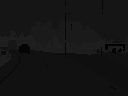

In [26]:
folder_path = '/Users/shared/.fastai/data/camvid_tiny/labels'
file_names = ['0006R0_f00960_P.png']
display_img(folder_path, file_names, 400, 400)
# all the images are very faint

In [27]:
import PIL.Image

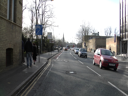

In [50]:
# displays in line
PIL.Image.open('/Users/shared/.fastai/data/camvid_tiny/images/0016E5_02250.png')

In [49]:
#open in a separate window
im = PIL.Image.open('/Users/shared/.fastai/data/camvid_tiny/images/0016E5_02250.png')
im.show()

## 4. Data
---

#### 4.1. Downaloading Data and ETL

How to download datasets - provided as tgz files.   
Default folder: `~/.fastai`

**untar_data**(url:str, fname:PathOrStr=None, dest:PathOrStr=None, data=True, force_download=False)

Note: `untar_data` only works for fastai datasets. In general, `untar_data` uses a `url` to download a tgz file under `fname`, and then un-tgz fname into a folder under `dest`.

**download_data**(url:str, fname:PathOrStr=None, data:bool=True, ext:str='.tgz') 

Download `url` to destination `fname`. Note: If the data file already exists in a `data` directory inside the notebook, that data file will be used instead of the one present in the default folder (`~/.fastai`). 

In [41]:
camvid = untar_data(URLs.CAMVID_TINY)   # untar_data 
path_lbl = camvid/'labels'   # labels
path_img = camvid/'images'   # images

# classes definition
codes = np.loadtxt(camvid/'codes.txt', dtype=str)    # classes
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'   # maps each image filename with corresponding mask filename

In [42]:
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [48]:
path_img.ls()

[PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_006750.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_006840.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_007500.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_007860.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_008070.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_008160.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_008400.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_008580.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_008670.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_008700.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_008760.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/images/0001TP_008940.png'),
 PosixPath('/Users/shared/.fastai/data/camvid_tiny/i

#### 4.2 Define data object

In [6]:
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=16, path=camvid)
        .normalize(imagenet_stats))

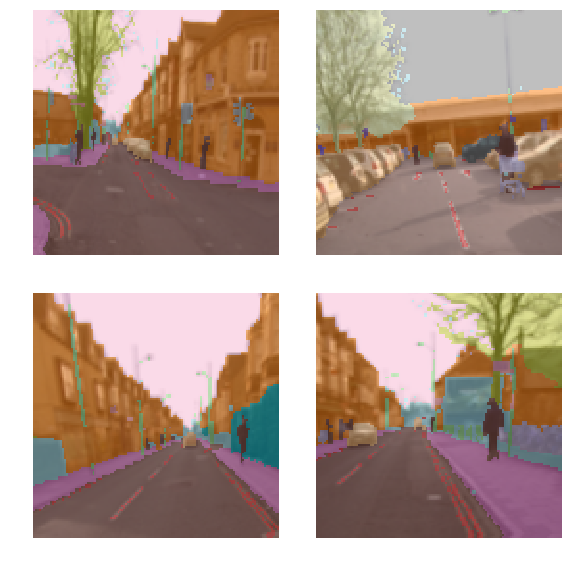

In [7]:
data.show_batch(rows=2, figsize=(8,8))

## 5. Training
---

#### **5.1. Model**

In [8]:
# simple CNN
#model = simple_cnn((3,16,16,2))    # syn
model = models.resnet18

#### **5.2. Learner**

Trainer for *model* using *data* to minimize *loss_func* with optimizer *opt_func*.

**Learner**(data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None, metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None, cb_fns_registered:bool=False)

In [9]:
#learn = Learner(data, model)
#learn = cnn_learner(data, model)
learn = unet_learner(data, model)

#### 5.2.1. Learning Rate Finder

lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)

In [ ]:
# run learning rate finder
learn.lr_find()

In [ ]:
# plot the finder results
learn.recorder.plot()

#### **5.3. Metrics**

In [16]:
# Metrics
# metrics always calculated on the validation set
#learn.metrics=[accuracy]    # accuracy does not work on multilabel classification

#### **5.4. Callbacks**

In [17]:
# Callbacks to modify training
#cb = OneCycleScheduler(learn, lr_max=0.01)   # this funciton not working


#### **5.5. Fit**

fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Point=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Optional[Collection[Callback]]=None, tot_epochs:int=None, start_epoch:int=None)

In [10]:
#n_epochs = 3
#learn.fit(epochs=n_epochs, callbacks=cb)
learn.fit_one_cycle(cyc_len=3, 1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,time
0,10.080372,2.741252,08:52
1,6.027252,2.071771,07:50
2,4.502634,2.038171,07:48


#### 6. Show Results
---

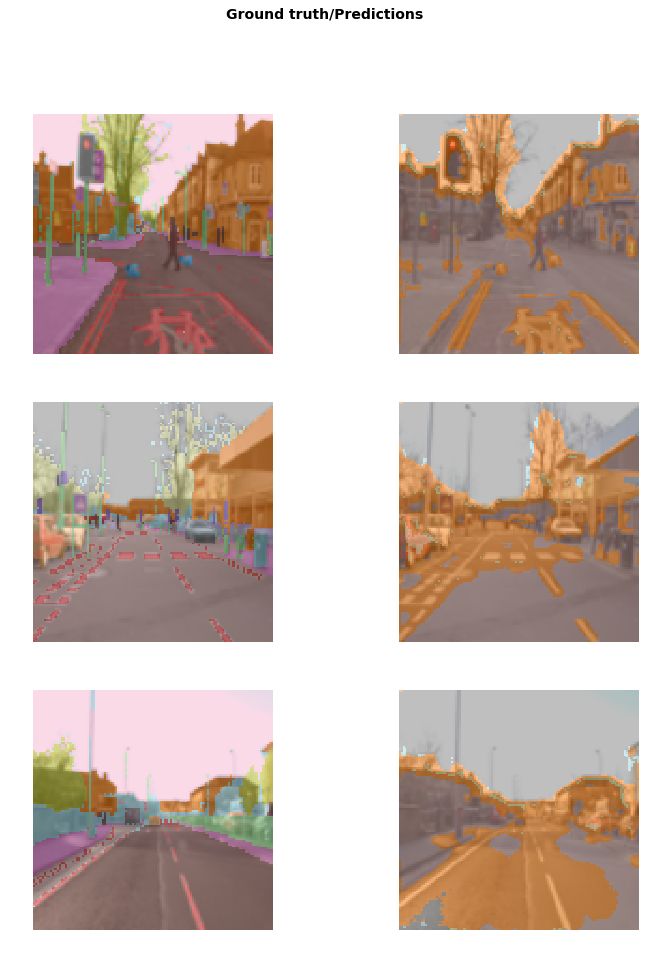

In [11]:
#learn.show_results()
learn.show_results(rows=3, figsize=(12,15))

## 7. Next Steps
---